# mean velocity of currents and wind

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
from os.path import join
import dask
import matplotlib.pyplot as plt
import cmocean
from caribbean_map import *

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40951")
client

<Client: 'tcp://127.0.0.1:40951' processes=6 threads=48, memory=251.28 GiB>

In [4]:
#!ls /nexsan/people/pmiron/data/GLBv0.08_caribbean/2010

In [5]:
base_folder = '/nexsan/people/pmiron/data/GLBv0.08_caribbean'
filenames = []
for year in range(2010, 2011):
    for type in ['c']:
        for h in range(0,24,3): # avoid reading filenames with hours > 21
            filenames.extend(glob.glob(join(base_folder, f'{year}', f'hycom_GLBv0.08*t0{h:02d}.nc')))
        filenames = sorted(filenames)

In [6]:
ds = xr.open_mfdataset(filenames, data_vars="minimal", decode_cf=False)
ds = xr.decode_cf(ds)

In [43]:
ds.isel(time=0)

<xarray.Dataset>
Dimensions:    (lat: 394, lon: 603)
Coordinates:
    time       datetime64[ns] 2010-01-01
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(394,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(603,), meta=np.ndarray>
    surf_u     (lat, lon) float32 dask.array<chunksize=(394, 603), meta=np.ndarray>
    surf_v     (lat, lon) float32 dask.array<chunksize=(394, 603), meta=np.ndarray>

In [15]:
month_length = ds.time.dt.days_in_month

In [36]:
ds

<xarray.Dataset>
Dimensions:    (time: 2887, lat: 394, lon: 603)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-12-31T21:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(394,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(603,), meta=np.ndarray>
    surf_u     (time, lat, lon) float32 dask.array<chunksize=(1, 394, 603), meta=np.ndarray>
    surf_v     (time, lat, lon) float32 dask.array<chunksize=(1, 394, 603), meta=np.ndarray>

In [37]:
# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")

# reorder the season
ds_weighted = ds_weighted.reindex({'season': ['DJF','MAM','JJA', 'SON']})

In [41]:
ds_weighted.surf_u[1].values

array([[-0.71237867, -0.71531948, -0.71860917, ...,  0.        ,
         0.        ,  0.        ],
       [-0.72510539, -0.7278617 , -0.73072138, ...,  0.        ,
         0.        ,  0.        ],
       [-0.73365958, -0.73616167, -0.73863568, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.12258711,
         0.11927678,  0.115117  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.14065066,
         0.13386026,  0.12531105],
       [ 0.        ,  0.        ,  0.        , ...,  0.14148007,
         0.13380223,  0.12647415]])

In [ ]:
base_folder = '/nexsan/people/pmiron/data/GLBv0.08_caribbean'
filenames_w = []
for year in range(2010, 2022):
    for type in ['c']:
        for h in range(0,24,3): # avoid reading filenames with hours > 21
            filenames_w.extend(glob.glob(join(base_folder, f'{year}w', f'JRA55_GLBv0.08*t0{h:02d}.nc')))
        filenames_w = sorted(filenames_w)

In [ ]:
ds_w = xr.open_mfdataset(filenames_w, data_vars="minimal", decode_cf=False)
ds_w = xr.decode_cf(ds_w)

In [ ]:
month_length_w = ds_w.time.dt.days_in_month

In [ ]:
# Calculate the weights by grouping by 'time.season'.
weights_w = (
    month_length_w.groupby("time.season") / month_length_w.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights_w.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted_w = (ds_w * weights_w).groupby("time.season").sum(dim="time")

# reorder the season
ds_weighted_w = ds_weighted_w.reindex({'season': ['DJF','MAM','JJA', 'SON']})

In [ ]:
ds_weighted.to_netcdf('seasonal_c.nc')
ds_weighted_w.to_netcdf('seasonal_w.nc')

In [17]:
# reload
ds_weighted = xr.open_dataset('seasonal_c.nc')
ds_weighted_w = xr.open_dataset('seasonal_w.nc')

In [28]:
lon = ds_weighted.longitude.isel(season=0).compute()
lat = ds_weighted.latitude.isel(season=0).compute()
lonw = ds_weighted_w.longitude.isel(season=0).compute()
latw = ds_weighted_w.latitude.isel(season=0).compute()

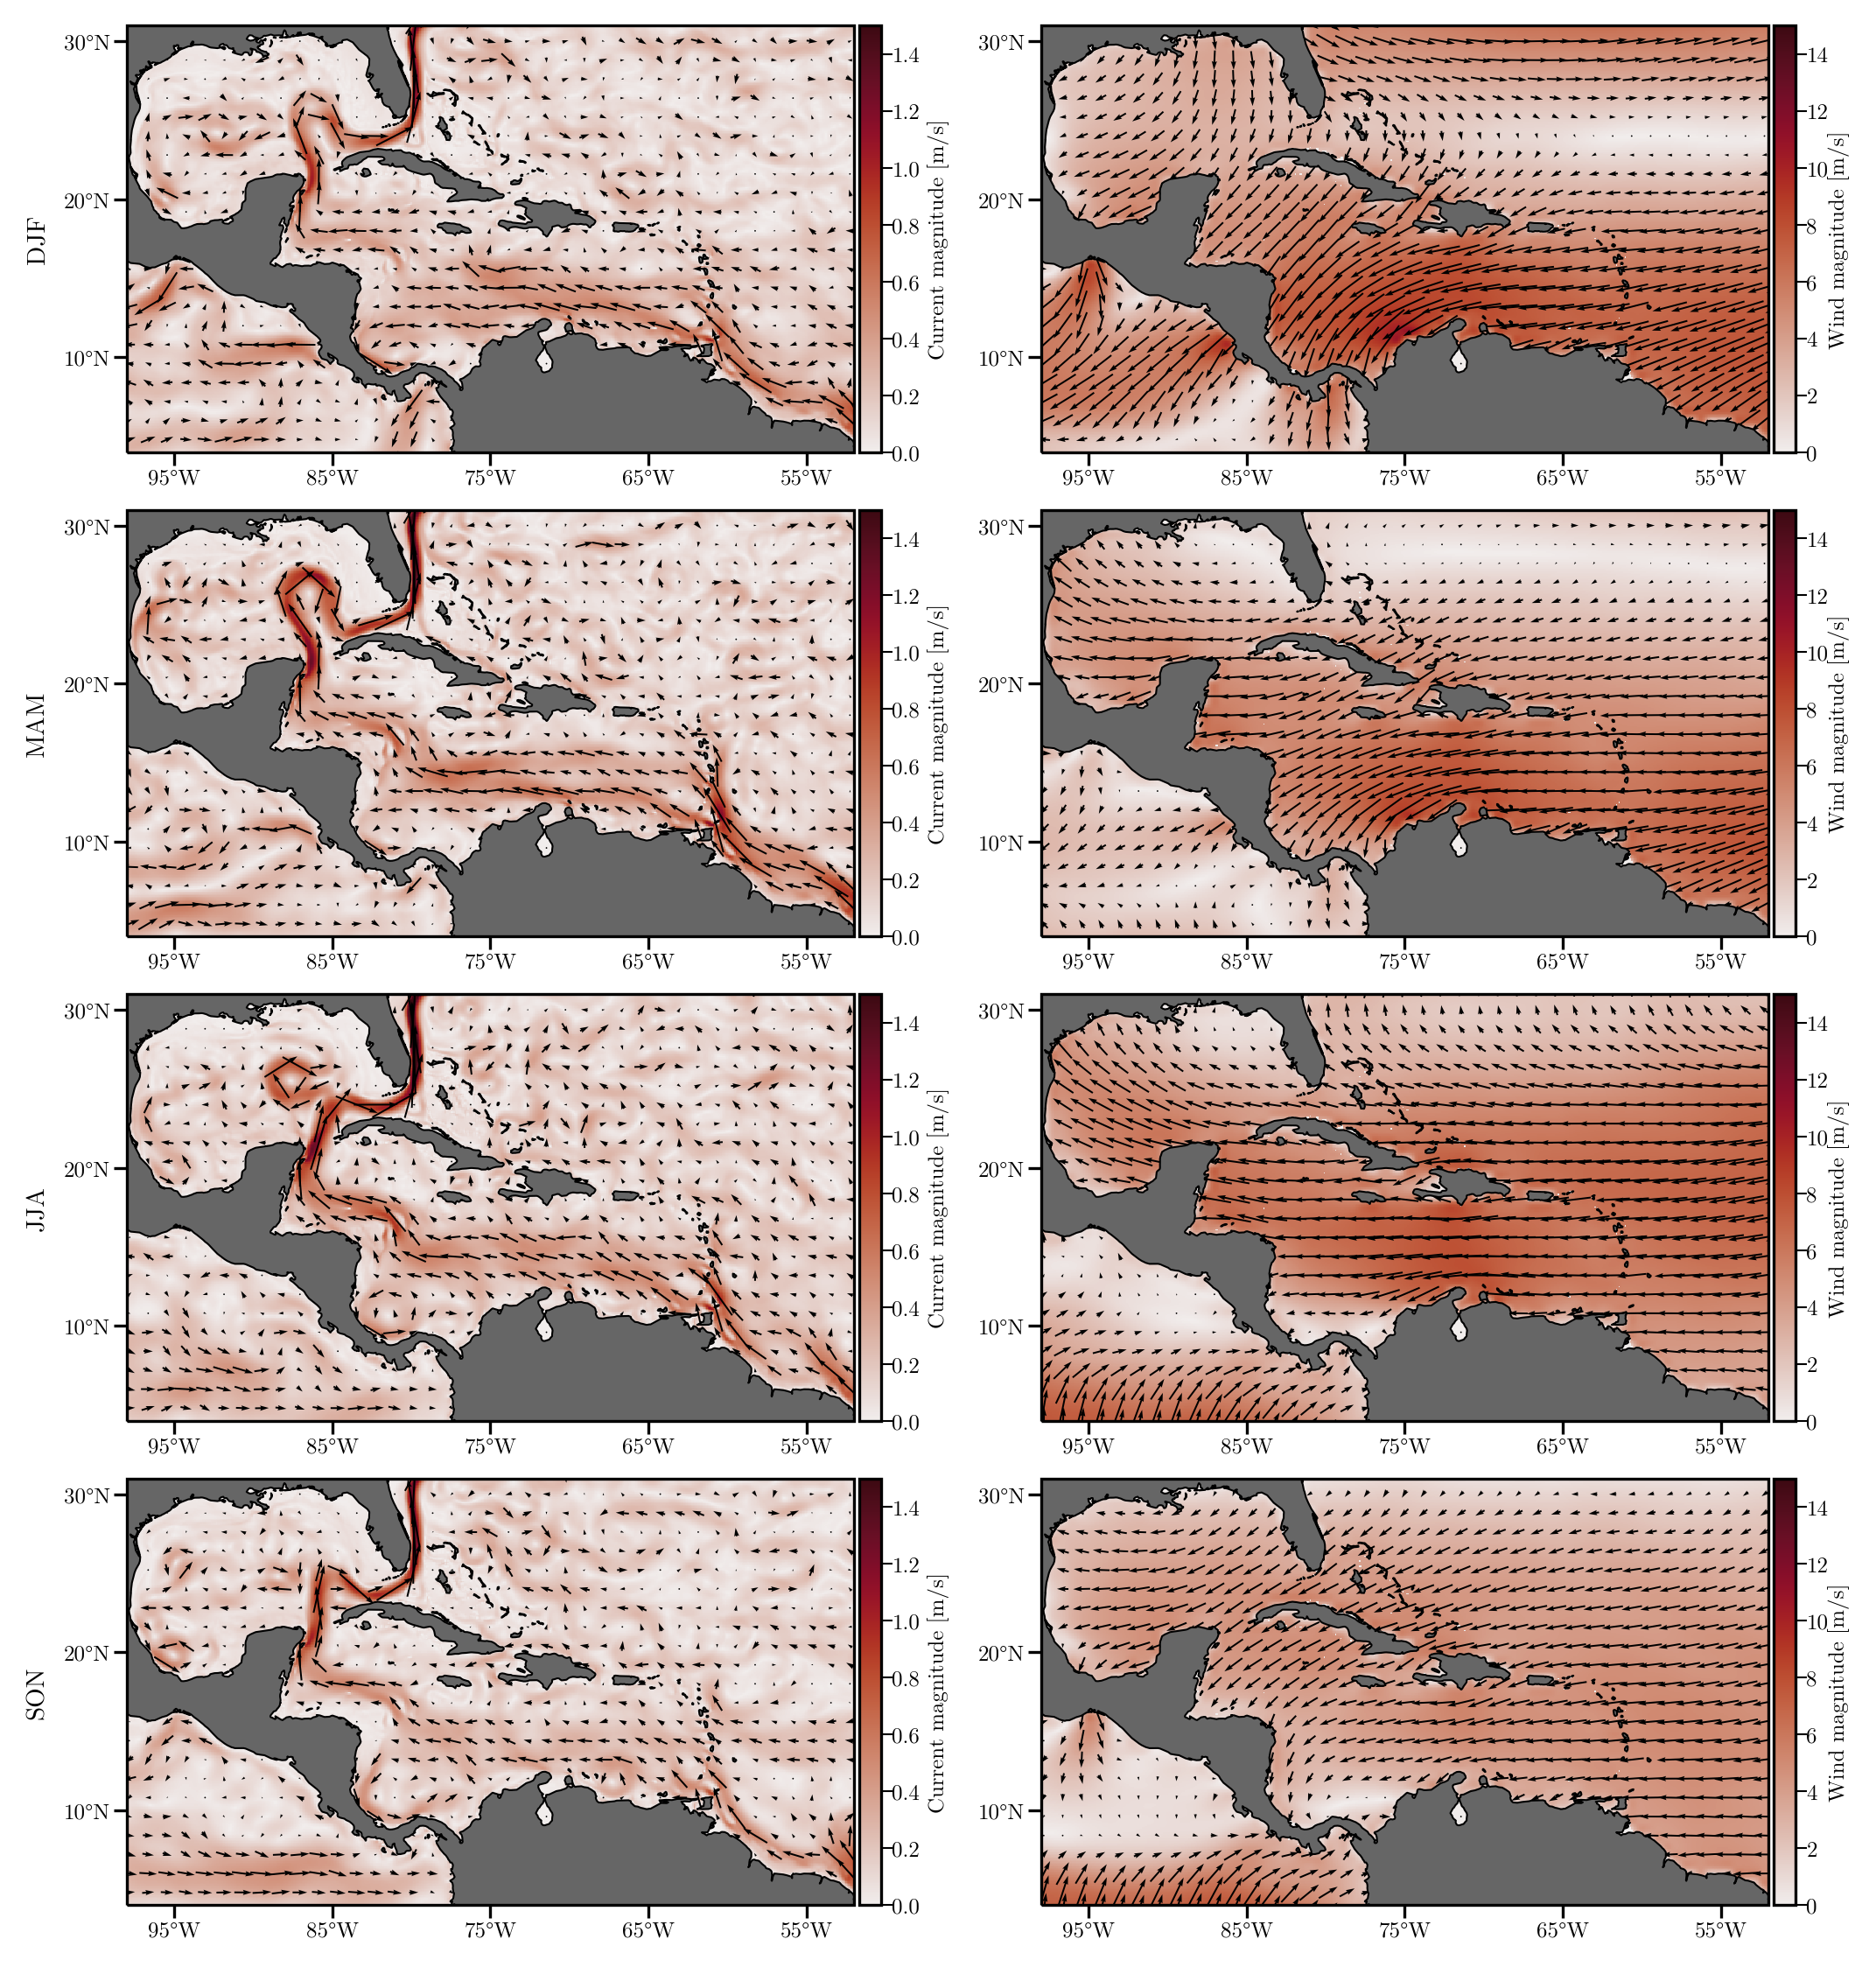

In [49]:
fig = plt.figure(dpi=300,figsize=(fs[0],fs[1]*1.8))
axes = fig.subplots(4,2,subplot_kw=dict(projection=ccrs.PlateCarree()))

skip = 15

seasons = ['DJF', 'MAM', 'JJA', 'SON']

for i in range(0,4):
    uc = ds_weighted.surf_u[i].compute()
    vc = ds_weighted.surf_v[i].compute()

    axes[i,0].set_ylabel(seasons[i],fontsize=7)
    pc = axes[i,0].pcolormesh(lon,lat,np.sqrt(uc**2+vc**2), cmap=cmocean.cm.amp, vmax=1.5)
    axes[i,0].quiver(lon[::skip],lat[::skip],
                     uc[::skip,::skip],vc[::skip,::skip], 
                     scale=5, scale_units='inches', 
                     pivot='mid')
    cb = add_colorbar(fig, axes[i,0], pc)
    cb.set_label('Current magnitude [m/s]', fontsize=6, labelpad=2)
    
    uw = ds_weighted_w.uwnd[i].compute()
    vw = ds_weighted_w.vwnd[i].compute()
    
    pc = axes[i,1].pcolormesh(lonw,latw,np.sqrt(uw**2+vw**2), cmap=cmocean.cm.amp, vmax=15)
    axes[i,1].quiver(lonw[::skip],latw[::skip],
                     uw[::skip,::skip],vw[::skip,::skip], 
                     scale=50, scale_units='inches', 
                     pivot='mid')
    cb = add_colorbar(fig, axes[i,1], pc)
    cb.set_label('Wind magnitude [m/s]', fontsize=6, labelpad=0)

for ax in axes.flatten():
    geo_map(ax)
    
fig.savefig('figures/seasonality_wf.png', format='png', dpi=600)

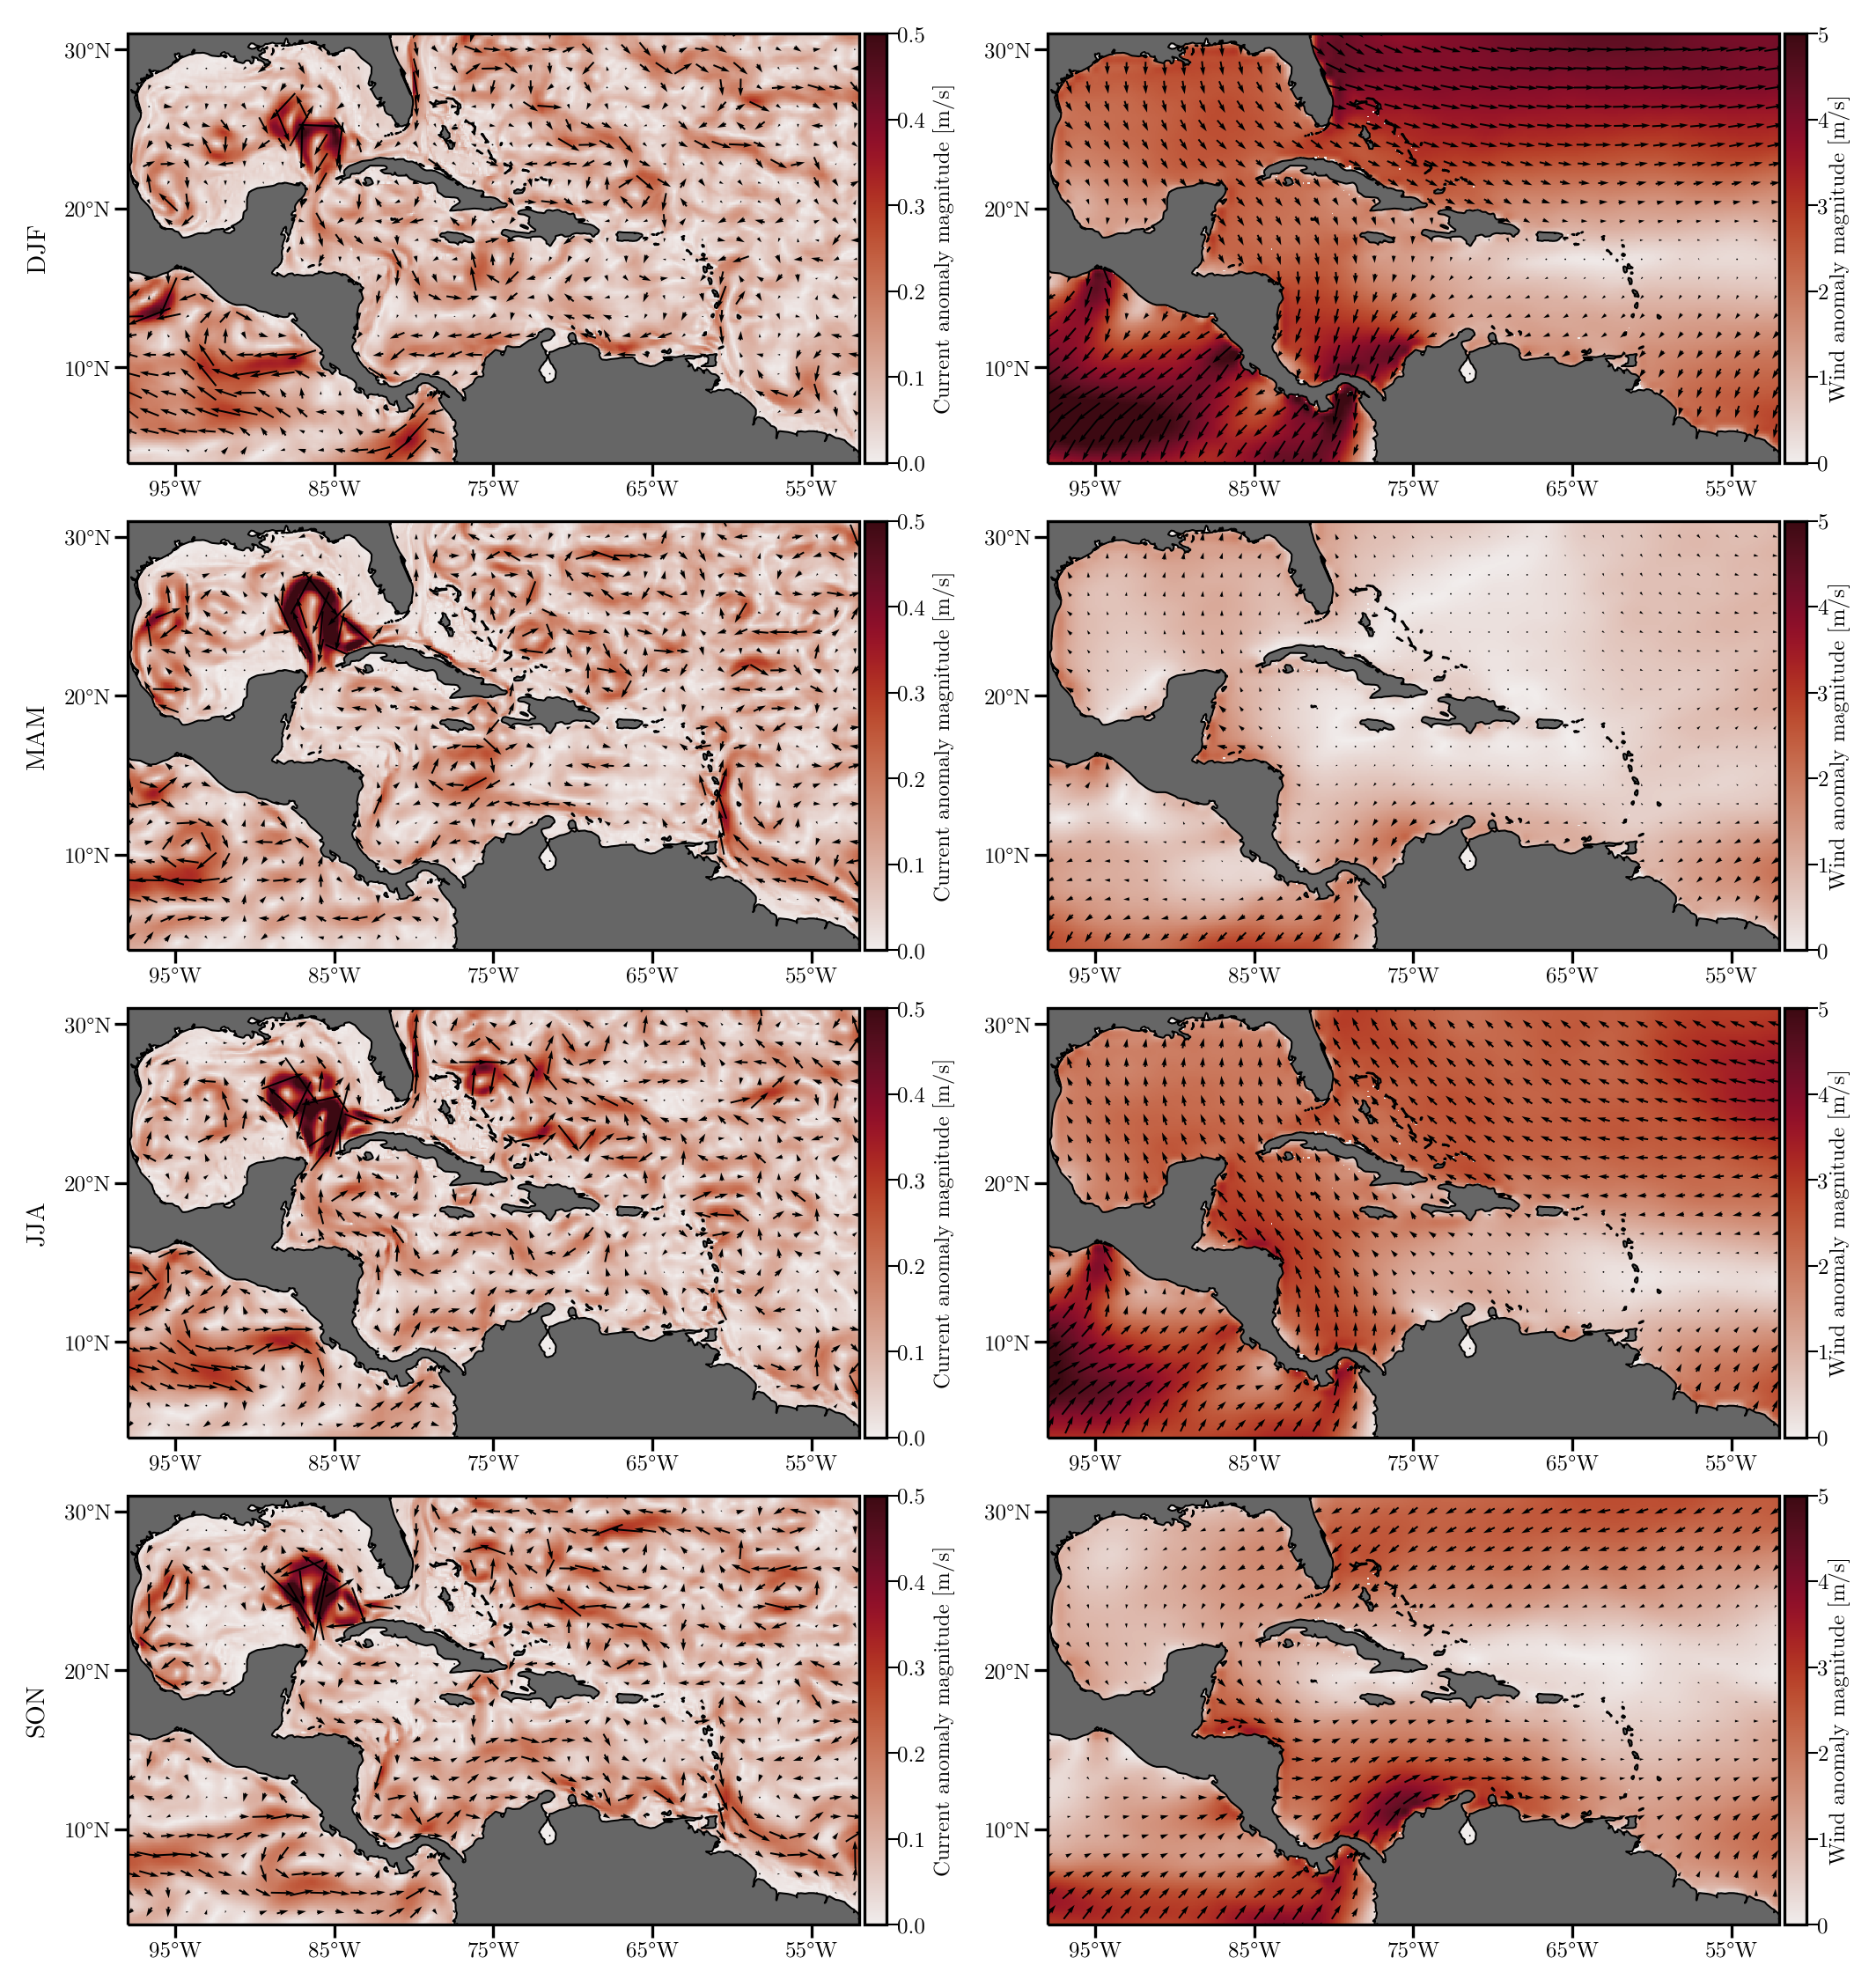

In [54]:
fig = plt.figure(dpi=300,figsize=(fs[0],fs[1]*1.8))
axes = fig.subplots(4,2,subplot_kw=dict(projection=ccrs.PlateCarree()))

skip = 15

seasons = ['DJF', 'MAM', 'JJA', 'SON']

for i in range(0,4):
    uc = (ds_weighted.surf_u[i] - ds_weighted.surf_u.mean("season")).compute()
    vc = (ds_weighted.surf_v[i] - ds_weighted.surf_v.mean("season")).compute()

    axes[i,0].set_ylabel(seasons[i],fontsize=7)
    pc = axes[i,0].pcolormesh(lon,lat,np.sqrt(uc**2+vc**2), cmap=cmocean.cm.amp, vmax=0.5)
    axes[i,0].quiver(lon[::skip],lat[::skip],
                     uc[::skip,::skip],vc[::skip,::skip], 
                     scale=2.5, scale_units='inches', 
                     pivot='mid')
    cb = add_colorbar(fig, axes[i,0], pc)
    cb.set_label('Current anomaly magnitude [m/s]', fontsize=6, labelpad=2)
    
    uw = (ds_weighted_w.uwnd[i] - ds_weighted_w.uwnd.mean("season")).compute()
    vw = (ds_weighted_w.vwnd[i] - ds_weighted_w.vwnd.mean("season")).compute()
    
    pc = axes[i,1].pcolormesh(lonw,latw,np.sqrt(uw**2+vw**2), cmap=cmocean.cm.amp, vmax=5)
    axes[i,1].quiver(lonw[::skip],latw[::skip],
                     uw[::skip,::skip],vw[::skip,::skip], 
                     scale=50, scale_units='inches', 
                     pivot='mid')
    cb = add_colorbar(fig, axes[i,1], pc)
    cb.set_label('Wind anomaly magnitude [m/s]', fontsize=6, labelpad=0)

for ax in axes.flatten():
    geo_map(ax)
    
fig.savefig('figures/seasonality_anomaly_wf.png', format='png', dpi=600)

In [75]:
fs[0], fs[1]*.5

(7.086614173228347, 2.05)

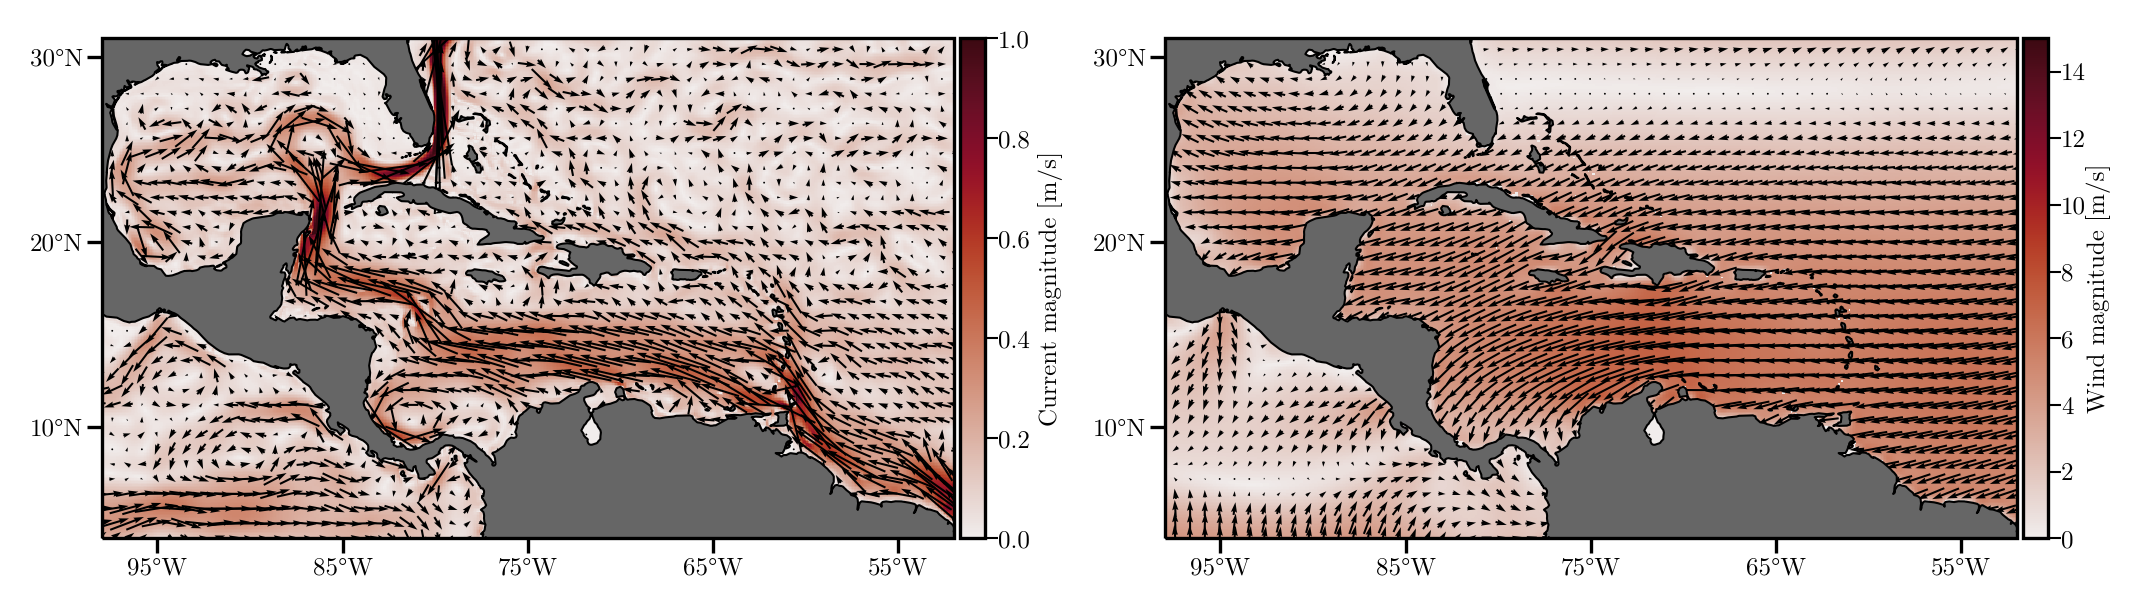

In [85]:
fig = plt.figure(dpi=300,figsize=(fs[0], fs[1]*.46))
axes = fig.subplots(1,2,subplot_kw=dict(projection=ccrs.PlateCarree()))

skip = 10

uc = ds_weighted.surf_u.mean("season").compute()
vc = ds_weighted.surf_v.mean("season").compute()

pc = axes[0].pcolormesh(lon,lat,np.sqrt(uc**2+vc**2), cmap=cmocean.cm.amp, vmax=1)
axes[0].quiver(lon[::skip],lat[::skip],
                 uc[::skip,::skip],vc[::skip,::skip], 
                 scale=2.5, scale_units='inches', 
                 pivot='mid')
cb = add_colorbar(fig, axes[0], pc)
cb.set_label('Current magnitude [m/s]', fontsize=6, labelpad=2)

uw = ds_weighted_w.uwnd.mean("season")
vw = ds_weighted_w.vwnd.mean("season")

pc = axes[1].pcolormesh(lonw,latw,np.sqrt(uw**2+vw**2), cmap=cmocean.cm.amp, vmax=15)
axes[1].quiver(lonw[::skip],latw[::skip],
                 uw[::skip,::skip],vw[::skip,::skip], 
                 scale=50, scale_units='inches', 
                 pivot='mid')
cb = add_colorbar(fig, axes[1], pc)
cb.set_label('Wind magnitude [m/s]', fontsize=6, labelpad=0)

for ax in axes.flatten():
    geo_map(ax)

    
fig.savefig('figures/mean_wf.png', format='png', dpi=600)